In [7]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

flags = tf.app.flags
FLAGS = flags.FLAGS

In [2]:
features = np.loadtxt(open("../100_final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
features = features.transpose()
features = stats.zscore(features)
n,d=features.shape
print(features.shape)
y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
y = y[0,:]

(93, 100)


In [3]:
bin_ixs = []
train_ixs = []
 
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(features, y):
    bin_ixs.append(test_index)
    
C = max(y) + 1  # number of classes

    
common = {}
common['dir_name']       = 'Chenxiao Testing'
common['num_epochs']     = 15
common['batch_size']     = 10
common['eval_frequency'] = common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'apool1'
common['filter']         = 'chebyshev5'

# Architecture.
common['F']              = [32, 64]  # Number of graph convolutional filters.
common['K']              = [20, 20]  # Polynomial orders.
common['p']              = [4, 2]    # Pooling sizes.
common['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
common['regularization'] = 5e-4
common['dropout']        = 0.7
common['learning_rate']  = 1e-3
common['decay_rate']     = 0.95
common['momentum']       = 0.9
#params['decay_steps']    = n_train / params['batch_size']

model_perf = utils.model_perf()    


 RUN: 0 **************************************************************************************************** 


 Fold: 0 **************************************************************************************************** 

d = |V| = 100, k|V| < |E| = 1488
Layer 0: M_0 = |V| = 104 nodes (4 added),|E| = 744 edges
Layer 1: M_1 = |V| = 52 nodes (0 added),|E| = 425 edges
Layer 2: M_2 = |V| = 26 nodes (0 added),|E| = 196 edges
Layer 3: M_3 = |V| = 13 nodes (0 added),|E| = 71 edges
Execution time: 0.25s
begin working!!!!!!!!
validation accuracy: peak = 100.00, mean = 100.00
INFO:tensorflow:Restoring parameters from /Users/ChenxiaoXu/Dropbox/BNL/Research/project1/code1_12_03/jiookcha-idp_jiook-87ca5154fa2f/lib/../checkpoints/Chenxiao TestingCGCNN/model-109
train accuracy: 94.52 (69 / 73), f1 (weighted): 94.53, loss: 1.19e+00
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /Users/ChenxiaoXu/Dropbox/BNL/Research/project1/code1_12_03/jiookcha-idp_jiook-87ca5154fa2f/lib/../checkpoin

validation accuracy: peak = 55.56, mean = 52.78
INFO:tensorflow:Restoring parameters from /Users/ChenxiaoXu/Dropbox/BNL/Research/project1/code1_12_03/jiookcha-idp_jiook-87ca5154fa2f/lib/../checkpoints/Chenxiao TestingCGCNN/model-114
train accuracy: 94.74 (72 / 76), f1 (weighted): 94.74, loss: 1.05e+00
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /Users/ChenxiaoXu/Dropbox/BNL/Research/project1/code1_12_03/jiookcha-idp_jiook-87ca5154fa2f/lib/../checkpoints/Chenxiao TestingCGCNN/model-114
test  accuracy: 75.00 (6 / 8), f1 (weighted): 75.00, loss: 1.83e+00
time: 1s (wall 1s)

 Fold: 9 **************************************************************************************************** 

d = |V| = 100, k|V| < |E| = 1440
Layer 0: M_0 = |V| = 104 nodes (4 added),|E| = 720 edges
Layer 1: M_1 = |V| = 52 nodes (2 added),|E| = 379 edges
Layer 2: M_2 = |V| = 26 nodes (1 added),|E| = 174 edges
Layer 3: M_3 = |V| = 13 nodes (0 added),|E| = 68 edges
Execution time: 0.07s
begin working!

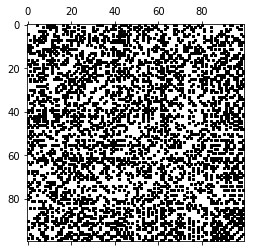

In [4]:
total_accuracies = []
all_scores = []
all_labels = []
sep = '*' * 100

for runs in range(1):
    print("\n RUN: {} {} \n".format(runs, sep))
    fold_acc = []
    roc_scores = []
    labels = []
    
    for i in range(skf.get_n_splits(features, y)):
        
        
        
        bins = list(range(skf.get_n_splits(features, y)))
        print("\n Fold: {} {} \n".format(i, sep))
        train_data = np.empty([0,features.shape[1]])
        train_labels = [] 
        val_ix = i
        if val_ix == max(bins):
            test_ix = 0
            bins.remove(val_ix)
            bins.remove(test_ix)

        else:
            test_ix = val_ix + 1
            bins.remove(test_ix)
            bins.remove(val_ix)

        val_data, val_labels = features[bin_ixs[val_ix]], y[bin_ixs[val_ix]]
        test_data, test_labels = features[bin_ixs[test_ix]], y[bin_ixs[test_ix]]
        for b in bins:
            train_data = np.concatenate((train_data, features[bin_ixs[b]]))
            train_labels = np.concatenate((train_labels, y[bin_ixs[b]]))

        
        t_start = time.process_time()
###################################################
#Chenxiao: generating permuational matrix
        dist, idx = graph.distance_scipy_spatial(train_data.transpose(), k=10, metric='euclidean')
        A = graph.adjacency(dist, idx).astype(np.float32)

        assert A.shape == (d, d)
        print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
        plt.spy(A, markersize=2, color='black')     
        
        graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)
        
        train_data = coarsening.perm_data(train_data, perm)
        val_data = coarsening.perm_data(val_data, perm)
        test_data = coarsening.perm_data(test_data, perm)

        L = [graph.laplacian(A, normalized=True) for A in graphs]
 #       graph.plot_spectrum(L)    
 ###################################################

        print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
        
        name = 'CGCNN'
        params = common.copy()
        params['dir_name'] += name             
        params['decay_steps'] = len(train_labels) / common['batch_size']
        
        print('begin working!!!!!!!!')
        model_perf.test(models.cgcnn(L, **params), name, params, 
                        train_data, train_labels, val_data, val_labels, test_data, test_labels, val_ix)
        
        scores, y_labels, test_accuracy = model_perf.show()   
        
        fold_acc = np.append(fold_acc, test_accuracy)
        roc_scores = np.append(roc_scores, scores)
        labels = np.append(labels, y_labels)  
        
    roc_scores = [roc_scores]
    labels = [labels]
    all_scores = np.append(all_scores, roc_scores)
    all_labels = np.append(all_labels, labels)
    fold_avg = np.mean(fold_acc)
    total_accuracies = np.append(total_accuracies, fold_avg)

In [5]:
print("Runs Avg: {}".format(np.mean(total_accuracies)))
print("Standard Deviation: {}".format(np.std(total_accuracies)))

Runs Avg: 88.83333333333333
Standard Deviation: 0.0


In [6]:
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

features = np.loadtxt(open("../100_final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
features = features.transpose()
features = stats.zscore(features)
y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
y = y[0,:]
lr_all_accs = []
lr_all_scores = []
svm_all_accs = []
svm_all_scores = []
base_labels = []
for runs in range(1):
    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []

    rbf = svm.SVC(kernel='linear')
    logistic = linear_model.LogisticRegression(C=1e5)

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(features, y):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = y[train_index], y[test_index]
        
        strat_labels = np.append(strat_labels, test_labels)

        log = logistic.fit(train_data, train_labels)
        log_prob = log.decision_function(test_data)
        log_acc = log.score(test_data, test_labels)
        lr_accuracies = np.append(lr_accuracies, log_acc)
        lr_scores = np.append(lr_scores, log_prob)
        #print('Logistic Regression Accuracy: %f' % log_acc)

        rbf = rbf.fit(train_data, train_labels)
        svm_acc = rbf.score(test_data, test_labels)
        svm_prob = rbf.decision_function(test_data)
        #print('SVM Accuracy: %f' % svm_acc)
        svm_accuracies = np.append(svm_accuracies, svm_acc)
        svm_scores = np.append(svm_scores, svm_prob)
   
    base_labels = np.append(base_labels, strat_labels)
    lr_all_scores = np.append(lr_all_scores, lr_scores)
    lr_fold_avg = np.mean(lr_accuracies)
    lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
    svm_all_scores = np.append(svm_all_scores, svm_scores)
    svm_fold_avg = np.mean(svm_accuracies)
    svm_all_accs = np.append(svm_all_accs, svm_fold_avg)

In [7]:
print("LR Avg: {}".format(np.mean(lr_all_accs)))
print("LR Standard Deviation: {}".format(np.std(lr_all_accs)))
print("SVM Avg: {}".format(np.mean(svm_all_accs)))
print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)))

LR Avg: 0.8372222222222223
LR Standard Deviation: 0.0
SVM Avg: 0.8397222222222223
SVM Standard Deviation: 0.0


[ 0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.]
[ 0.02154803  0.11352192  0.01379588  0.99885869  0.97677213  0.5577035
  0.98232573  0.05408479  0.8017863   0.17173089  0.96469414  0.17914917
  0.07635127  0.02688567  0.96893901  0.22371918  0.1046661   0.99456429
  0.98435289  0.9736138   0.83399028  0.03809804  0.38429913  0.96916729
  0.98520768  0.65386808  0.74047101  0.10229725  0.08491085  0.10388403
  0.96466786  0.99555224  0.96609515  0.96530658  0.99453896  0.103668
  0.10950042  0.07501207  0.15434508  0.70282805  0.99965978  0.90767932
  0.99600631  0.08799019  0.1770862   0.03407989  0.00247457  0.11455122
  0.95749885  0.99410915  0.86814433  0.

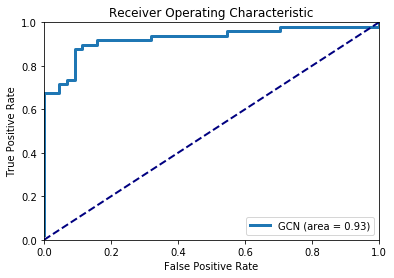

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

#fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
#roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
#fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
#roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

print(all_labels)
print(all_scores)

plt.figure()
#plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'])
#plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (area = %0.2f)' % roc_auc['svm'])
plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('10x_Combined_ROC.eps')
plt.show()